In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import shapiro
import os
import seaborn as sns


# Import
In this first section we load the data. After this the index of the dataframe is set and also Nan columns and dropped.

In [25]:
df= pd.read_csv (os.getcwd()+'/Output//Finaldf.csv')
#df.set_index(['Country', 'Year'], inplace=True)
df.dropna(axis = 1, inplace = True)
df


    


,Country,Year,% Undernourishment,AgriShareGDP,CreditToAgriFishForest,EmploymentRural,GDP,%EmploymentAgriFishForest,TotalAgri,Gender Inequality,...,Civil Liberties,Freedom of Expression,% Healthcare Investment,% Employment Industry,Women Schooling Years,Men Schooling Years,% Education Expenditure,% Men Employment,% Women Employment,Population
0,Spain,1990,2.5,3.67764,1.161677,3727.392,5.365278e+05,11.9,31925046.0,0.1570,...,0.978,0.962,12.58,33.262,8.4,9.0,10.11695,58.15,24.75,39202524.0
1,Spain,1991,2.5,3.67764,1.161677,3727.392,5.771466e+05,10.9,31925046.0,0.1570,...,0.978,0.962,12.58,33.262,8.4,9.0,10.00686,57.48,25.03,39299081.0
2,Spain,1992,2.5,3.67764,1.161677,3727.392,6.309051e+05,9.8,30390528.0,0.1570,...,0.978,0.962,12.58,33.162,8.4,9.0,9.70611,57.24,25.87,39410852.0
3,Spain,1993,2.5,3.67764,1.161677,3596.249,5.251096e+05,9.8,25086968.0,0.1570,...,0.978,0.962,12.58,31.036,8.4,9.0,10.02190,53.56,25.03,39533726.0
4,Spain,1994,2.5,3.67764,1.161677,3561.345,5.305603e+05,9.5,26580385.0,0.1570,...,0.978,0.962,12.58,30.264,8.4,9.0,10.24136,52.20,24.86,39660079.0
5,Spain,1995,2.5,3.67764,1.161677,3528.645,6.146123e+05,9.0,27694580.0,0.1570,...,0.978,0.962,12.58,30.206,8.4,9.0,10.63163,52.73,25.57,39787413.0
6,Spain,1996,2.5,3.67764,1.161677,3519.995,6.426300e+05,8.4,34298174.0,0.1494,...,0.981,0.962,12.58,29.472,8.4,9.0,10.70875,52.97,26.30,39908962.0
7,Spain,1997,2.5,3.67764,1.161677,3653.638,5.901017e+05,8.0,31352677.0,0.1418,...,0.981,0.962,12.58,29.914,8.4,9.0,10.59799,54.03,27.42,40035286.0
8,Spain,1998,2.5,3.67764,1.161677,3761.787,6.192259e+05,7.7,30137459.0,0.1342,...,0.981,0.962,12.58,30.517,8.4,9.0,10.48723,55.80,28.20,40201561.0
9,Spain,1999,2.5,3.67764,1.161677,3915.211,6.346747e+05,7.2,27579190.0,0.1266,...,0.981,0.962,12.58,30.682,8.4,9.0,10.69392,57.94,30.20,40454472.0


# Correlation matrix
With the .corr() the correlation matrix is displayed. As we can see the % Undernoruishment row still has to be treated. 

In [3]:
cor=df.corr()
cor

,Year,% Undernourishment,AgriShareGDP,CreditToAgriFishForest,EmploymentRural,GDP,%EmploymentAgriFishForest,TotalAgri,Gender Inequality,% Soldiers,...,Civil Liberties,Freedom of Expression,% Healthcare Investment,% Employment Industry,Women Schooling Years,Men Schooling Years,% Education Expenditure,% Men Employment,% Women Employment,Population
Year,1.000000,NaN,-0.739958,0.270418,-0.253816,0.853058,-0.916666,0.862073,-0.980589,-0.885543,...,-0.344017,-0.759080,0.904672,-0.927430,0.931312,0.934125,-0.215631,-0.353577,0.886609,0.944896
% Undernourishment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AgriShareGDP,-0.739958,NaN,1.000000,0.200682,-0.254934,-0.955836,0.822923,-0.796245,0.724084,0.813643,...,-0.095642,0.308939,-0.813501,0.675323,-0.743949,-0.782882,0.110046,0.103025,-0.882199,-0.907241
CreditToAgriFishForest,0.270418,NaN,0.200682,1.000000,-0.747249,-0.015807,-0.041456,0.181434,-0.194859,-0.090878,...,-0.385964,-0.400166,0.263457,-0.162498,0.155503,0.136459,0.080350,-0.001573,0.062205,0.021396
EmploymentRural,-0.253816,NaN,-0.254934,-0.747249,1.000000,0.084861,-0.079388,-0.154466,0.168620,0.018421,...,0.675247,0.546673,-0.131916,0.363629,-0.307992,-0.263157,0.282888,0.523951,0.134062,-0.013514
GDP,0.853058,NaN,-0.955836,-0.015807,0.084861,1.000000,-0.887389,0.921379,-0.822685,-0.871015,...,-0.012674,-0.446710,0.911627,-0.759856,0.822688,0.856461,-0.081153,-0.133966,0.936227,0.959607
%EmploymentAgriFishForest,-0.916666,NaN,0.822923,-0.041456,-0.079388,-0.887389,1.000000,-0.792584,0.926694,0.872334,...,0.021105,0.499420,-0.848406,0.769169,-0.772931,-0.794446,-0.016382,0.112834,-0.957891,-0.931735
TotalAgri,0.862073,NaN,-0.796245,0.181434,-0.154466,0.921379,-0.792584,1.000000,-0.810775,-0.797701,...,-0.228269,-0.578243,0.894853,-0.797217,0.851438,0.870764,-0.168621,-0.245805,0.836561,0.899697
Gender Inequality,-0.980589,NaN,0.724084,-0.194859,0.168620,-0.822685,0.926694,-0.810775,1.000000,0.878579,...,0.305318,0.733478,-0.862338,0.887775,-0.895046,-0.896176,0.203355,0.283291,-0.895990,-0.928404
% Soldiers,-0.885543,NaN,0.813643,-0.090878,0.018421,-0.871015,0.872334,-0.797701,0.878579,1.000000,...,0.219043,0.591911,-0.880554,0.786809,-0.832798,-0.849428,0.247000,0.182667,-0.898327,-0.919989


# Heatmap
A heatmap is a great way to visualize the correlation between the variables. If there is a really close correlation between 2 varialbes they might be explaining the same behaviour, in the future it might be a reason to drop one of them.

<AxesSubplot:>

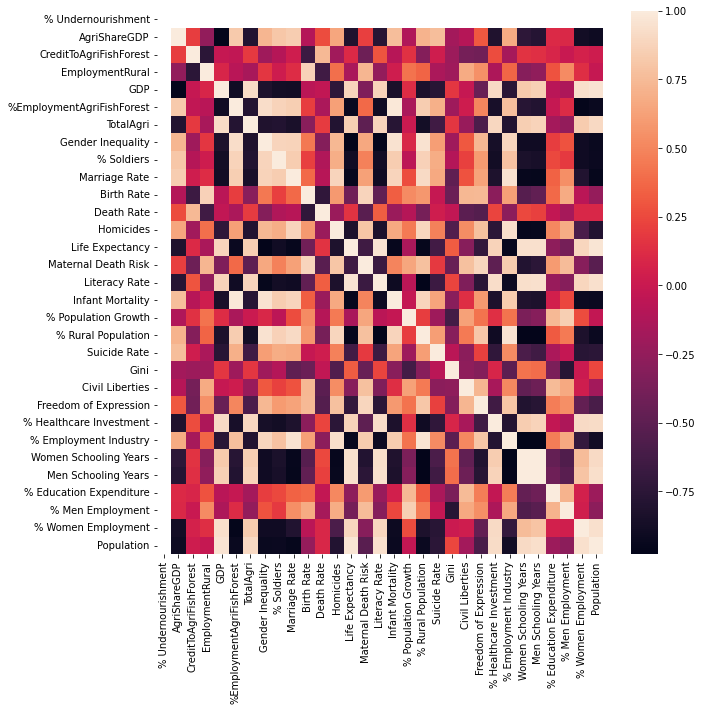

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cor)

# The correlation table with GDP
From this display we can start extracting valuable data in order to start deciding which of them are going to be used or not.

In [46]:
corcolumn=cor[['GDP']].sort_values(by = 'GDP',ascending = False).style.background_gradient()
display(corcolumn)


,GDP
GDP,1.000000
Population,0.959607
% Women Employment,0.936227
TotalAgri,0.921379
% Healthcare Investment,0.911627
Life Expectancy,0.882003
Literacy Rate,0.872430
Men Schooling Years,0.856461
Women Schooling Years,0.822688
Gini,0.170784
